# Homework 5

In [1]:
using FiniteDifferences, SparseArrays, LinearAlgebra, Plots, LaTeXStrings, FFTW, LaTeXStrings, Printf
import Base: diff, *

## Question 1

What do centered difference look like?

In [ ]:
method = FiniteDifferenceMethod([-2,-1, 0, 1,2], 3)
display(method)

Let's implement the method 

In [ ]:
function solve_airy(m,η,stop)
    L = 1
    h = 2/(1+m)
    k = 0.01
    xs = -1:h:1-h
    h = L*h
    xs = L*xs

    D3 = diagm(1 => fill(-2,m), -1 => fill(2,m), -2 => fill(-1,m-1), 2 => fill(1,m-1)) |> sparse
    D3[1,m] = -1
    D3[1,m+1] = 2
    D3[2,m+1] = -1
    D3[m+1,1] = -2
    D3[m+1,2] = 1
    D3[m,1] = 1
    
    U = η.(xs)
    for t=k:k:stop
        U =  (I + k/(4*h^3)*D3) \ ((I-k/(4*h^3)*D3)*U)
    end
    return xs, U
end

In [ ]:
η = x -> abs(x) < 0.5 ? 1 : 0
ts = [0.25,0.50,0.75,1.0] #we want rational numbers of the period length

for i=1:length(ts)
    t = ts[i]
    sol = solve_airy(499,η,ts[i])
    graph = plot(sol[1],sol[2],label="t=$t")
    display(graph)
    savefig(graph,joinpath("..","pdf","images","1-"*string(i)*".png")) 
end

## Question 2

In [ ]:
method = FiniteDifferenceMethod([-1, 0, 1], 1)
display(method)

In [ ]:
function Newton(U,U0,m,F,DF)
    count = 0
    New_U = U0
    update = fill(100,m+1)
    while maximum(abs.(update)) > 1e-10
        count += 1
        if count == 300
            @printf("No convergence")
        break
        end
        update = DF(New_U)\F(New_U,U)
        New_U = New_U - update
    end
    return New_U
end

In [ ]:
function solveKdV(m,η,stop)
    L = 10
    h = 2/(1+m)
    k = 0.01
    xs = -1:h:1-h
    h = L*h
    xs = L*xs

    D3 = diagm(1 => fill(-2,m), -1 => fill(2,m), -2 => fill(-1,m-1), 2 => fill(1,m-1)) |> sparse
    D3[1,m] = -1
    D3[1,m+1] = 2
    D3[2,m+1] = -1
    D3[m+1,1] = -2
    D3[m+1,2] = 1
    D3[m,1] = 1

    D1 = diagm(1 => fill(1,m),-1 => fill(-1,m)) |> sparse
    D1[1,m+1] = -1
    D1[m+1,1] = 1

    #define things
    f = (y,x) -> (y + (3*k)/(2*h)*y .* (D1*y) + k/(4*h^3)*D3*y) + (-x + (3*k)/(2*h)*x .* (D1*x) + k/(4*h^3)*D3*x)
    Df = x -> I + k/(4*h^3)*D3 + (3*k)/(2*h)*(Diagonal(D1 * x) + Diagonal(x)*D1)
    
    #solve the linear case to get init cond
    U = η.(xs) 
    ULinear = η.(xs)

    for t=k:k:stop
        #run newton's method 
        ULinear = (I + k/(4*h^3)*D3) \ ((I-k/(4*h^3)*D3)*ULinear)
        U = Newton(U,ULinear,m,f,Df)
    end  
    return xs,U
end

In [ ]:
η =  x -> 4*(sech(x))^2
ts = [0.1,1,2,4] #we want rational numbers of the period length

for i=1:length(ts)
    t = ts[i]
    sol = solveKdV(499,η,ts[i])
    graph = plot(sol[1],sol[2],label="t=$t")
    display(graph)
    savefig(graph,joinpath("..","pdf","images","2-"*string(i)*".png")) 
end

In [ ]:
function solveKdV(m,η,stop)
    L = 10
    h = 2/(1+m)
    k = 0.01
    xs = -1:h:1-h
    h = L*h
    xs = L*xs

    D3 = diagm(1 => fill(-2,m), -1 => fill(2,m), -2 => fill(-1,m-1), 2 => fill(1,m-1)) |> sparse
    D3[1,m] = -1
    D3[1,m+1] = 2
    D3[2,m+1] = -1
    D3[m+1,1] = -2
    D3[m+1,2] = 1
    D3[m,1] = 1

    D1 = diagm(1 => fill(1,m),-1 => fill(-1,m)) |> sparse
    D1[1,m+1] = -1
    D1[m+1,1] = 1

    #define things
    f = (y,x) -> (y + (3*k)/(2*h)*y .* (D1*y) + k/(4*h^3)*D3*y) + (-x + (3*k)/(2*h)*x .* (D1*x) + k/(4*h^3)*D3*x)
    Df = x -> I + k/(4*h^3)*D3 + (3*k)/(2*h)*(Diagonal(D1 * x) + Diagonal(x)*D1)
    
    #solve the linear case to get init cond
    U = η.(xs) 
    ULinear = η.(xs)

    theta = range(0, stop = 2π, length = 100)
    x = cos.(theta)
    y = sin.(theta)
    graph = plot(x, y, aspect_ratio=:equal, linewidth=3, color="red", legend=false)
    jcount = 0;
    for t=k:k:stop
        ULinear = (I + k/(4*h^3)*D3) \ ((I-k/(4*h^3)*D3)*ULinear)
        
        #run newton's method 
        count = 0
        New_U = ULinear
        update = fill(100,m+1)
        while maximum(abs.(update)) > 1e-10
            count += 1
            if count == 300
                @printf("No convergence")
            break
            end
            update = Df(New_U)\f(New_U,U)

            #compute evals
            evals = eigvals(Df(New_U) |> Matrix)
            bur = z -> (1-z)/(1+z)
            λmap = bur.(k*evals)
            graph = plot!(real(λmap),imag(λmap),seriestype=:scatter,xaxis=[-1.1,1.1],legend=false)
            jcount += 1

            New_U = New_U - update
        end
        U = New_U
    end  
    return xs,U,graph,jcount
end

In [ ]:
sol = solveKdV(499,η,0.30)

In [ ]:
ts = [0.15,0.30,0.6,1.20] 

values = [0,0,0,0]

for i=1:length(ts)
    t = ts[i]
    sol = solveKdV(499,η,ts[i])
    values[i] = sol[4]
    display(sol[4])
    display(sol[3])
    savefig(sol[3],joinpath("..","pdf","images","3b-"*string(i)*".png")) 
end

## Question 3

In [2]:
mfftshift = x -> circshift(fftshift(x), isodd(length(x)) ? 1 : 0)
mfft = x -> fftshift(fft(fftshift(x),1)) # fft(x,1) is used so that
# when we operate on matrices below, the behavior is as desired.
mifft = x -> mfftshift(ifft(mfftshift(x),1))
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n
diffvec = (L,m,j) -> ((-floor(m/2):1:floor((m-1)/2))*(1im*pi/L)).^j

#9 (generic function with 1 method)

In [3]:
function rk4(F,k,t,c)
    f1 = k*F(c,t)
    f2 = k*F(c + .5*f1, t + .5*k)
    f3 = k*F(c + .5*f2, t + .5*k)
    f4 = k*F(c + f3, t + k)
    return c + 1/6.0*(f1 + 2.0*f2 + 2.0*f3 + f4)
end

rk4 (generic function with 1 method)

In [ ]:
anim = Animation()
T = 4
μ = 0.1
ϵ = 0.1 
S(x) = μ * log.(cosh.(x))
A = x -> - sech.(x)
η = x -> A.(x).*exp.(1im*S.(x)/ϵ)

L = 50.
m = 2^10
k = 0.0001

X = mgrid(m,L)
c = mfft(η(X))
U = mifft(c)
cl = [-2,2]

d2 = (ϵ* 1im)/(2)*diffvec(L,m,2)

N = v -> (1im/ϵ)*v.*abs2.(v)

F = (v,τ) -> exp.(-d2*τ).*(mfft(N(mifft(exp.(d2*τ).*v))))

n = convert(Int64,ceil(T/k))
t = 0.0
plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("Re u(x,t), t = %1.2f",t))
plot!(X, U |> imag, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("Im u(x,t), t = %1.2f",t)) #|> IJulia.display
frame(anim)
fr = 50 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    c = exp.(d2*k).*rk4(F,k,0.0,c)
    t += k
    U = mifft(c)
    if mod(i-1,tb) ≈ 0.0
        #IJulia.clear_output(true)
        #|> real        
        plot(X, abs2.(U) , xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("Re u(x,t), t = %1.2f",t) ) 
        #plot!(X, U |> imag, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("Im u(x,t), t = %1.2f",t) ) #|> IJulia.display  
        frame(anim)
    end
end
gif(anim,"kdv_gauss.gif")

In [4]:
function solve_shrody(ϵ,k,T,L,m)
    μ = 0.1
    S(x) = μ * log.(cosh.(x))
    A = x -> - sech.(x)
    η = x -> A.(x).*exp.(1im*S.(x)/ϵ)

    X = mgrid(m,L)
    c = mfft(η(X))
    U = mifft(c)
    cl = [-2,2]

    d2 = (ϵ* 1im)/(2)*diffvec(L,m,2)

    N = v -> (1im/ϵ)*v.*abs2.(v)

    F = (v,τ) -> exp.(-d2*τ).*(mfft(N(mifft(exp.(d2*τ).*v))))


    n = convert(Int64,ceil(T/k))

    ts = 0:k:T
    z = zeros(size(X)[1],n+1)
    #z = zeros(floor(size(X,1)/factor)|>Int,size(ts,1))
    #z[:,1] = abs2.(U)[1:factor:end]

    for i = 2:n+1
        c = exp.(d2*k).*rk4(F,k,0.0,c)
        U = mifft(c)
        z[:,i] = abs2.(U)#[1:factor:end]
    end 
    return ts,X,z
end

solve_shrody (generic function with 1 method)

In [6]:
cont1 = solve_shrody(0.1,0.001,4,25,2^15)
cont2 = solve_shrody(0.05,0.001,4,25,2^15)

(0.0:0.001:4.0, -25.0:0.00152587890625:24.99847412109375, [0.0 7.891718049736438e-22 … 7.027714668789895e-17 7.572389473690588e-17; 0.0 7.891639753470831e-22 … 7.040203654576239e-17 7.518725685928024e-17; … ; 0.0 7.891725746431679e-22 … 7.056435205075784e-17 7.355700957838382e-17; 0.0 7.891619151244511e-22 … 7.04020348608452e-17 7.518725568326712e-17])

#### IS L chillin?

In [18]:
max_l = maximum(cont1[3][1,:])
max_r = maximum(cont1[3][end,:])
print(max_l,"and",max_r)

3.28135217179093e-11and2.4169893980594823e-11

In [19]:
max_l = maximum(cont2[3][1,:])
max_r = maximum(cont2[3][end,:])
print(max_l,"and",max_r)

5.658338560671543e-7and2.971566893335267e-7

#### Check number of nodes

In [20]:
cont1_half = solve_shrody(0.1,0.001,4,25,2^15/2)
cont2_half = solve_shrody(0.05,0.001,4,25,2^15/2)

(0.0:0.001:4.0, -25.0:0.0030517578125:24.9969482421875, [0.0 7.902817977211917e-22 … 6.660823768919698e-10 9.377771698348934e-10; 0.0 7.898115162543837e-22 … 7.928408957032325e-13 2.020038621772015e-12; … ; 0.0 7.882407296455905e-22 … 6.369869542599756e-10 8.903398635491834e-10; 0.0 7.89814768953961e-22 … 7.928409305892299e-13 2.0200386769632053e-12])

In [29]:
dif1 = cont1_half[3] - cont1[3][1:2:end,:]
dif2 = cont2_half[3] - cont2[3][1:2:end,:]

maxdif1 = maximum(dif1)
maxdif2 = maximum(dif2)

print(maxdif1,"and",maxdif2)

6.266898111562114e-11and4.624698917155001e-7

#### Create Contour 

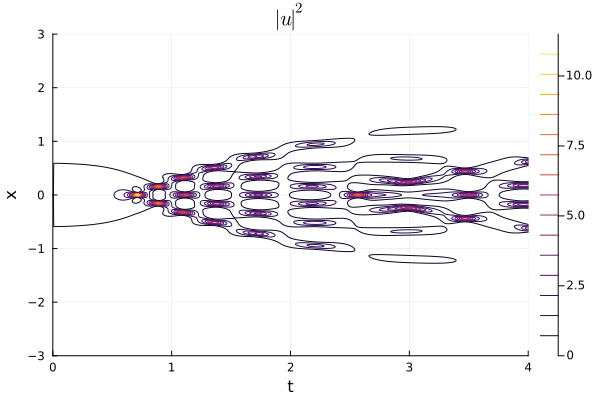

"c:\\Users\\admin\\Documents\\GitHub\\UW\\2022-2023\\Spring\\AMATH_586\\HW5\\src\\pdf\\images\\3-1.png"

In [8]:
factor = 8

ct = contour(cont[1][1:factor:end],cont[2],cont[3][:,1:factor:end],yaxis=[-3,3],xlabel="t",ylabel="x",title=L"|u|^2")
display(ct)
savefig(ct,joinpath("..","pdf","images","3-1.png"))

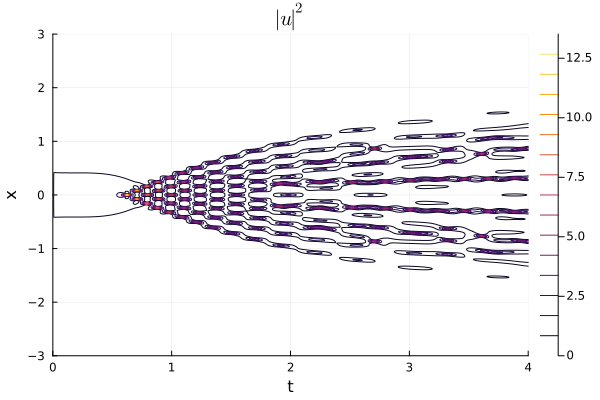

In [6]:
factor = 8

ct = contour(cont2[1][1:factor:end],cont2[2],cont2[3][:,1:factor:end],yaxis=[-3,3],xlabel="t",ylabel="x",title=L"|u|^2")
display(ct)
savefig(ct,joinpath("..","pdf","images","3-2.png"))

## Question 4

In [ ]:
struct trig_interp
    L::Float64
    c::Vector{Complex{Float64}}
end

function (tr::trig_interp)(x) # just sums the Fourier series!
    m = length(tr.c)
    mm = convert(Int64,floor( m/2 ))
    σ = isodd(m) ? 1im*pi/m : 0. # if n is odd we need to rotate coefs
    ex = exp.(-1im*pi*mm*x/tr.L + mm*σ)
    ex1 = exp.(1im*pi*x/tr.L-σ)
    sum = tr.c[1]*ex
    for i = 2:length(tr.c)
        ex  =  ex.*ex1
        sum += tr.c[i]*ex
    end
    return sum/m
end

function disk_eval(tr::trig_interp,x,r) # just sums the Laurent series!
    m = length(tr.c)
    mm = convert(Int64,floor( m/2 ))
    σ = isodd(m) ? 1im*pi/m : 0. # if n is odd we need to rotate coefs
    ex = exp.(mm*σ)
    ex1 = exp.(1im*pi*x/tr.L-σ)*r
    sum = tr.c[mm+1]
    for i = mm+2:length(tr.c)
        ex  =  ex.*ex1
        sum += tr.c[i]*ex
    end
    return sum/m
end

diffvec = (L,m,j) -> ((-floor(m/2):1:floor((m-1)/2))*(1im*pi/L)).^j

In [ ]:
function stable_eval(f,z,rad)
    n = 2^2
    cs = mfft(map(f,rad*exp.(1im*mgrid(n,pi))))
    while maximum(abs.(cs[1:4])) > 1e-14 || maximum(abs.(cs[end-3:end])) > 1e-14
        n = 4*n
        cs = mfft(map(f,rad*exp.(1im*mgrid(n,pi))))
        if n > 1e5
            print("Did not achieve tolerance")
            display(maximum(abs.(cs[1:4])) + maximum(abs.(cs[end-3:end])))
            break
        end
    end
    tr = trig_interp(pi,cs)
    map( z -> abs(z) > rad/2 ? f(z) : disk_eval(tr,angle(z),abs(z/rad)), z |> complex)
end

In [ ]:
mfftshift = x -> circshift(fftshift(x), isodd(length(x)) ? 1 : 0)
mfft = x -> fftshift(fft(fftshift(x),1)) # fft(x,1) is used so that
# when we operate on matrices below, the behavior is as desired.
mifft = x -> mfftshift(ifft(mfftshift(x),1))
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n

In [ ]:
f0 = z -> (exp(z/2)-1)/z
f1 = z -> (-4 - z + exp(z)*(4-3z+z^2))/z^3
f2 = z -> 2*(2 + z + exp(z)*(-2 + z))/z^3
f3 = z -> (-4 - 3z - z^2 + exp(z)*(4-z))/z^3

In [ ]:
anim = Animation()
η = x ->  cos.(x ./ 16) .* (1 .+ sin.(x ./ 16))

L = 16 * pi
N = 2^10
X = mgrid(N,L)
c = mfft(η(X))
D1 = diffvec(L,N,1)
D2 = diffvec(L,N,2)
D4 = diffvec(L,N,4)
U = mifft(c)
cl = [-10,10]
k = 0.1
t = 0.0


#N = u -> u.^2.0.*(1 .- u).*(u .- 2.0)
#N = u -> -u .* D1 .* u
#NF = c -> mfft(N(mifft(c)))
#NF = c -> mfft(-mifft(c) * mifft(D1 * c))

# N = u -> -u.*mifft(D1.*mfft(u))
# NF = c -> mfft(N(mifft(c)))

# N = u -> -u.*mifft(D1.*mfft(u))
NF = c -> mfft(-mifft(c).*mifft(D1.*c))



S0 = Diagonal(exp.(-(D2+D4)*k/2))
S1 = Diagonal(exp.(-(D2+D4)*k))


E0 = k*stable_eval(f0, -(D2+D4)*k, 2) |> Diagonal
E1 = k*stable_eval(f1, -(D2+D4)*k, 2) |> Diagonal
E2 = k*stable_eval(f2, -(D2+D4)*k, 2) |> Diagonal
E3 = k*stable_eval(f3, -(D2+D4)*k, 2) |> Diagonal

plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) #|> IJulia.display
frame(anim)



for i = 2:1500
    t += k
    aa = S0*c + E0*NF(c)
    bb = S0*c + E0*NF(aa)
    cc = S0*aa + E0*(2*NF(bb)-NF(c))
    c = S1*c + E1*NF(c) + E2*(NF(aa) + NF(bb)) + E3*NF(cc)
    # IJulia.clear_output(true)        
    plot(X, mifft(c) |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) #|> IJulia.display  
    frame(anim)
end

gif(anim,"nonlinear_heat_4th.gif")


In [ ]:
η = x ->  cos.(x ./ 16) .* (1 .+ sin.(x ./ 16))

L = 16 * pi
N = 2^10
X = mgrid(N,L)
c = mfft(η(X))
D1 = diffvec(L,N,1)
D2 = diffvec(L,N,2)
D4 = diffvec(L,N,4)
U = mifft(c)
cl = [-10,10]
k = 0.1
#t = 0.0

NF = c -> mfft(-mifft(c).*mifft(D1.*c))

S0 = Diagonal(exp.(-(D2+D4)*k/2))
S1 = Diagonal(exp.(-(D2+D4)*k))

E0 = k*stable_eval(f0, -(D2+D4)*k, 2) |> Diagonal
E1 = k*stable_eval(f1, -(D2+D4)*k, 2) |> Diagonal
E2 = k*stable_eval(f2, -(D2+D4)*k, 2) |> Diagonal
E3 = k*stable_eval(f3, -(D2+D4)*k, 2) |> Diagonal

ts = 0:k:150
z = zeros(size(X)[1],size(ts)[1])

for i = 2:1500
    #t += k
    aa = S0*c + E0*NF(c)
    bb = S0*c + E0*NF(aa)
    cc = S0*aa + E0*(2*NF(bb)-NF(c))
    c = S1*c + E1*NF(c) + E2*(NF(aa) + NF(bb)) + E3*NF(cc)
    z[:,i] = mifft(c) |> real
end

In [ ]:
X

In [ ]:
ct = contour(ts,X,z)
display(ct)
savefig(ct,joinpath("..","pdf","images","4.png"))